# Recriar Estudo 6 - FLAME

In [1]:
import sys
print(sys.executable)

/home/magda/tf-gpu-env/bin/python3.10


**Ver se está a usar a GPU**

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2025-06-24 20:35:18.056739: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-24 20:35:19.167616: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5186929091154010667
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2351693824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14871252888292668165
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2025-06-24 20:35:20.916187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 20:35:20.969145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 20:35:20.969199: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 20:35:21.163275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 20:35:21.163360: I tensorflow/compile

**imports**

In [3]:
import os
# Ativa o alocador assíncrono (melhora fragmentação de memória)
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
# Ativa a alocação dinâmica de memória (não ocupa toda a memória no início)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Erro ao definir memory growth:", e)
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, 
                                     GlobalMaxPooling2D, Dense, Dropout, BatchNormalization, AveragePooling2D,
                                     Concatenate, Flatten, LayerNormalization, Multiply, Add, Activation, Reshape)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_auc_score

print("TensorFlow:", tf.__version__)
print("TensorFlow Addons:", tfa.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)

2025-06-24 20:35:21.177322: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 20:35:21.177594: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 20:35:21.177696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
/home/magda/tf-gpu-env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.


TensorFlow: 2.13.0
TensorFlow Addons: 0.21.0
NumPy: 1.23.5
Pandas: 1.5.3
Matplotlib: 3.7.1


## Arquitetura do Modelo:

In [4]:
def channel_attention(input_feature, reduction_ratio=8):
    channel = input_feature.shape[-1]

    shared_dense_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='glorot_uniform')
    shared_dense_two = Dense(channel, activation='relu', kernel_initializer='glorot_uniform')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    max_pool = GlobalMaxPooling2D()(input_feature)

    avg_out = shared_dense_two(shared_dense_one(avg_pool))
    max_out = shared_dense_two(shared_dense_one(max_pool))

    cbam_feature = Add()([avg_out, max_out])
    cbam_feature = Activation('relu')(cbam_feature)
    cbam_feature = Reshape((1, 1, channel))(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

# Atenção espacial com layer norm, conv 7x7 e gating
def spatial_attention(input_feature):
    avg_pool = tf.reduce_mean(input_feature, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(input_feature, axis=-1, keepdims=True)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    concat = LayerNormalization()(concat)

    conv = Conv2D(1, kernel_size=7, padding='same', activation='relu')(concat)
    gate = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')(concat)
    gated = Multiply()([conv, gate])

    return Multiply()([input_feature, gated])

# Bloco AHC: convoluções paralelas com pooling
def AHC_block(input_tensor):
    conv_3x3 = Conv2D(32, kernel_size=3, padding='same', activation='relu')(input_tensor)
    conv_5x5 = Conv2D(32, kernel_size=5, padding='same', activation='relu')(input_tensor)
    conv_7x7 = Conv2D(32, kernel_size=7, padding='same', activation='relu')(input_tensor)

    pool_3x3 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_3x3)
    pool_5x5 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_5x5)
    pool_7x7 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_7x7)

    return Concatenate()([pool_3x3, pool_5x5, pool_7x7])

# Modelo completo AHMHCNN-mCBAM
def build_AHMHCNN_mCBAM(input_shape=(256, 256, 3), num_classes=2):
    inputs = Input(shape=input_shape)

    # MHCNN base convolucional
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(48, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(64, kernel_size=5, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.02)(x)
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.02)(x)

    # Bloco AHC
    x = AHC_block(x)

    # Bloco mCBAM
    x = channel_attention(x)
    x = spatial_attention(x)

    # Classificação
    x = Flatten()(x)
    x = Dense(56, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(48, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Criar o modelo
model = build_AHMHCNN_mCBAM()

2025-06-24 20:35:22.066090: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 20:35:22.066201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 20:35:22.066236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 20:35:22.066499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 20:35:22.066513: I tensorflow/core/co

In [5]:
# Compilar o modelo
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=2, average='macro')
    ]
)

In [6]:
# Mostrar resumo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 48)         13872     ['max_pooling2d[0][0]']   

## Funções Auxiliares

Trata do pré-processamento das imagens, ou seja redimensiona para 224 X 224 pixels e normaliza [0,1] e coloca em one hot.

In [7]:
# Função auxiliar para carregar imagem
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    label = tf.one_hot(label, 2)
    return image, label

Permite analisar a distribuição dos datasets.

In [8]:
def inspect_dataset_distribution(dataset, name="dataset"):
    total_samples = 0
    label_counter = Counter()

    for images, labels in dataset:
        # labels vêm em one-hot: [0,1] ou [1,0]
        labels_np = labels.numpy()
        class_indices = labels_np.argmax(axis=1)  # <-- Corrigir: pegar o índice da classe correta
        total_samples += len(class_indices)
        label_counter.update(class_indices)

    print(f"📊 {name.upper()} -> Total de imagens: {total_samples}")
    for label, count in sorted(label_counter.items()):
        perc = (count / total_samples) * 100
        print(f"  Classe {int(label)} ({'Fogo' if label == 1 else 'Sem fogo'}): {count} imagens ({perc:.2f}%)")
    print("-" * 40)

Permite analisar o histórico de trino.

In [9]:
def plot_training_history(history):
    metrics = history.history.keys()
    epochs_range = range(len(history.history['loss']))

    for metric in metrics:
        if "val_" not in metric:
            plt.figure(figsize=(10, 5))
            plt.plot(epochs_range, history.history[metric], label=f"Train {metric}")
            if f"val_{metric}" in metrics:
                plt.plot(epochs_range, history.history[f"val_{metric}"], label=f"Val {metric}")
            plt.title(f"Training and Validation {metric.capitalize()}")
            plt.xlabel("Epochs")
            plt.ylabel(metric.capitalize())
            plt.legend()
            plt.grid(True)
            plt.show()

Usada para avaliar o modelo, ou seja, se está a prever corretamente a classificação das imagens.

In [10]:
def avaliar_modelo(model, dataset):
    # 1. Previsões e rótulos reais
    y_pred_probs = model.predict(dataset, verbose=0)
    y_true = np.concatenate([y for _, y in dataset], axis=0)
    y_true_int = np.argmax(y_true, axis=1)
    y_pred_int = (y_pred_probs[:, 1] > 0.5).astype(int)

    # 2. Contagem das classes
    TP = np.sum((y_true_int == 1) & (y_pred_int == 1))
    TN = np.sum((y_true_int == 0) & (y_pred_int == 0))
    FP = np.sum((y_true_int == 0) & (y_pred_int == 1))
    FN = np.sum((y_true_int == 1) & (y_pred_int == 0))

    total = TP + TN + FP + FN

    # 3. Cálculo das métricas com base nas fórmulas
    accuracy   = (TP + TN) / total if total > 0 else 0.0
    precision  = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall     = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score   = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    auc        = roc_auc_score(y_true_int, y_pred_probs[:, 1])

    # Binary crossentropy loss
    eps = 1e-7
    p = np.clip(y_pred_probs[:, 1], eps, 1 - eps)
    y = y_true_int
    loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

    # Métricas específicas de detecção de incêndio
    fdr = recall * 100  # ou (TP / (TP + FN)) * 100
    ewr = ((FP + FN) / total) * 100 if total > 0 else 0.0

    # 4. Impressão
    print("=== MÉTRICAS DE AVALIAÇÃO ===")
    print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-Score       : {f1_score:.4f}")
    print(f"AUC            : {auc:.4f}")
    print(f"Binary Loss    : {loss:.4f}")
    print(f"FDR (Fire Detection Rate)      : {fdr:.2f} %")
    print(f"EWR (Error Warning Rate)       : {ewr:.2f} %")
    print("Confusion Matrix:")
    print(np.array([[TN, FP], [FN, TP]]))  # [[negativos reais], [positivos reais]]

    # 5. Retorno opcional
    return {
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'auc': auc,
        'loss': loss,
        'fdr': fdr,
        'ewr': ewr,
        'confusion_matrix': np.array([[TN, FP], [FN, TP]])
    }

## Treino

In [11]:
# Configurações gerais
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16
EPOCHS = 50
SEED = 42

In [12]:
data = pd.read_csv("../Datasets/Estudo2_Recriado.csv")
image_paths = data['image_path'].values
labels = data['label_bi'].values

In [13]:
# Dividir em treino, validação e teste (80/10/10)
x_train, x_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.2, random_state=SEED, stratify=labels)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

In [14]:
# Criar datasets TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess_image).shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
inspect_dataset_distribution(train_ds, name="train")
inspect_dataset_distribution(val_ds, name="val")
inspect_dataset_distribution(test_ds, name="test")

📊 TRAIN -> Total de imagens: 4492
  Classe 0 (Sem fogo): 2209 imagens (49.18%)
  Classe 1 (Fogo): 2283 imagens (50.82%)
----------------------------------------
📊 VAL -> Total de imagens: 562
  Classe 0 (Sem fogo): 276 imagens (49.11%)
  Classe 1 (Fogo): 286 imagens (50.89%)
----------------------------------------
📊 TEST -> Total de imagens: 561
  Classe 0 (Sem fogo): 276 imagens (49.20%)
  Classe 1 (Fogo): 285 imagens (50.80%)
----------------------------------------


In [16]:
# Função do agendamento de learning rate conforme o estudo
def custom_lr_schedule(epoch, lr):
    if epoch < 15:
        return 1e-4
    elif epoch < 25:
        return 1e-5
    else:
        return 1e-6

# Callbacks combinados
callback = [
    ModelCheckpoint('Recriar_Estudo_6_FLAME_best.h5', monitor='val_loss', save_best_only=True, verbose=1),
    LearningRateScheduler(custom_lr_schedule, verbose=1)
]

In [17]:
# Treinar
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callback
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/50


2025-06-24 20:35:27.018920: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-06-24 20:35:27.630195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-06-24 20:35:28.643719: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2d50090ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-24 20:35:28.643766: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-06-24 20:35:28.651428: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-24 20:35:28.783242: I ./tensorflow/compiler/jit/device_compiler.h:186] Compil

281/281 [==============================] - ETA: 0s - loss: 0.2536 - accuracy: 0.9014 - precision: 0.9014 - recall: 0.9014 - auc: 0.9611 - f1_score: 0.9013
Epoch 1: val_loss improved from inf to 0.68975, saving model to Recriar_Estudo_6_FLAME_best.h5
281/281 [==============================] - 39s 106ms/step - loss: 0.2536 - accuracy: 0.9014 - precision: 0.9014 - recall: 0.9014 - auc: 0.9611 - f1_score: 0.9013 - val_loss: 0.6898 - val_accuracy: 0.4911 - val_precision: 0.4911 - val_recall: 0.4911 - val_auc: 0.6963 - val_f1_score: 0.3294 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/50


/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/281 [==============================] - ETA: 0s - loss: 0.1295 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9906 - f1_score: 0.9550
Epoch 2: val_loss improved from 0.68975 to 0.17692, saving model to Recriar_Estudo_6_FLAME_best.h5
281/281 [==============================] - 26s 93ms/step - loss: 0.1295 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9906 - f1_score: 0.9550 - val_loss: 0.1769 - val_accuracy: 0.9644 - val_precision: 0.9644 - val_recall: 0.9644 - val_auc: 0.9949 - val_f1_score: 0.9644 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/50
281/281 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9936 - f1_score: 0.9630
Epoch 3: val_loss improved from 0.17692 to 0.08113, saving model to Recriar_Estudo_6_FLAME_best.h5
281/281 [==============================] - 26s 92ms/step - loss: 0.1072 - accuracy: 0.9630 - precision: 0.9630

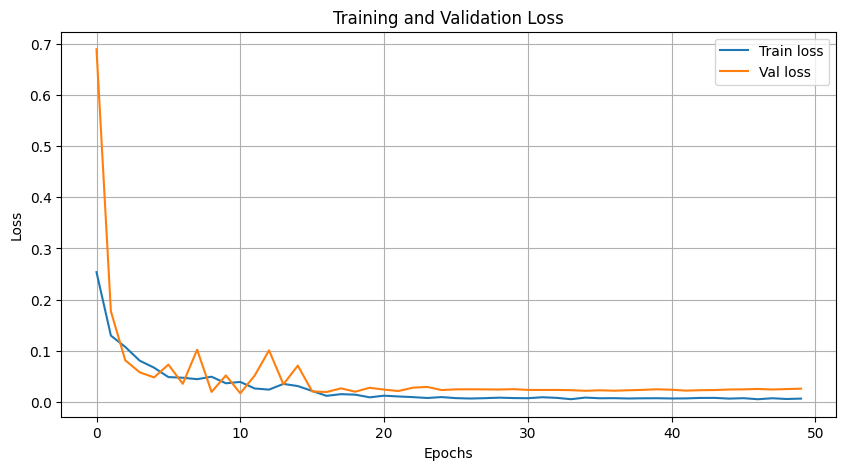

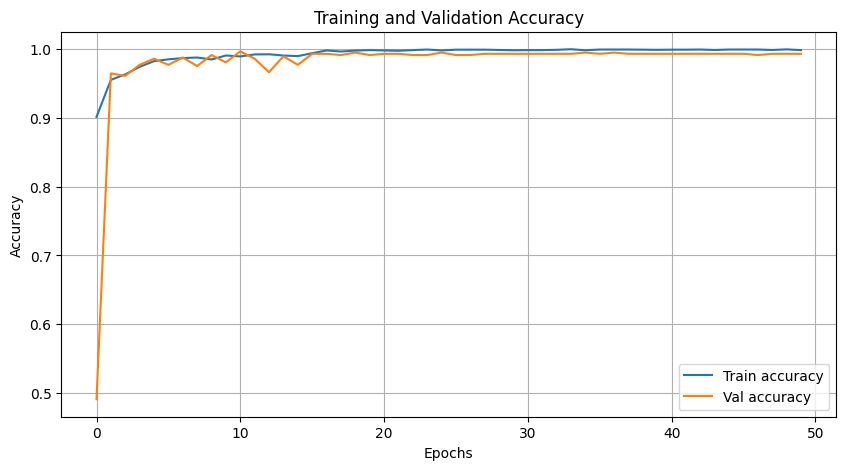

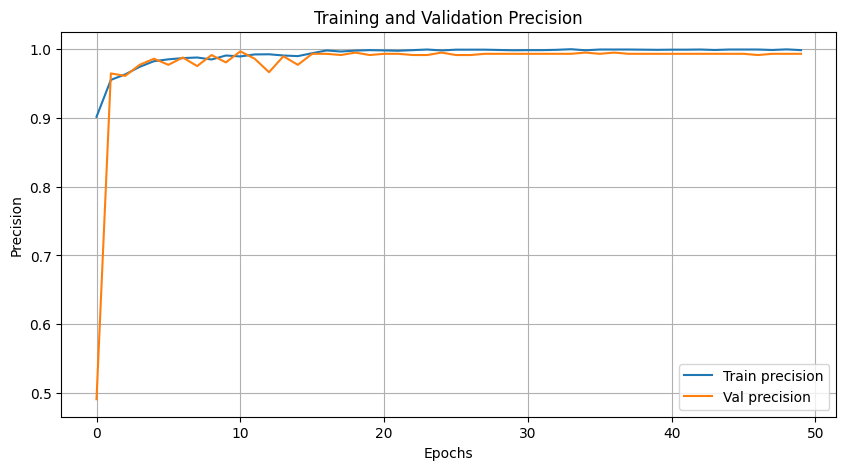

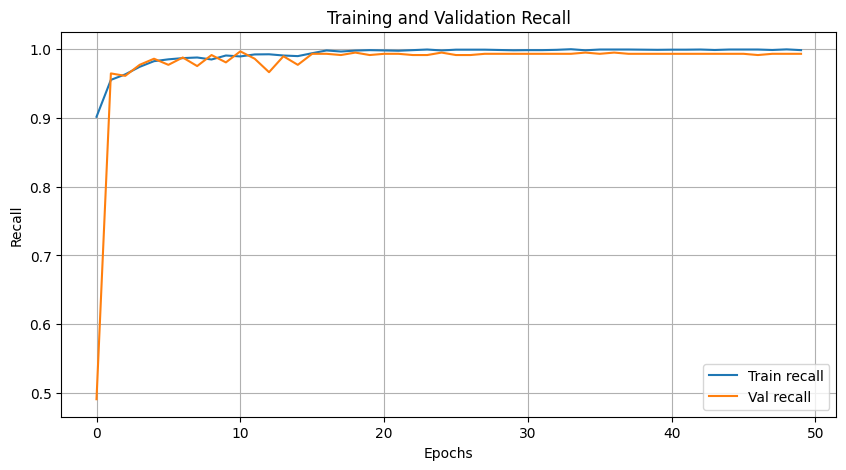

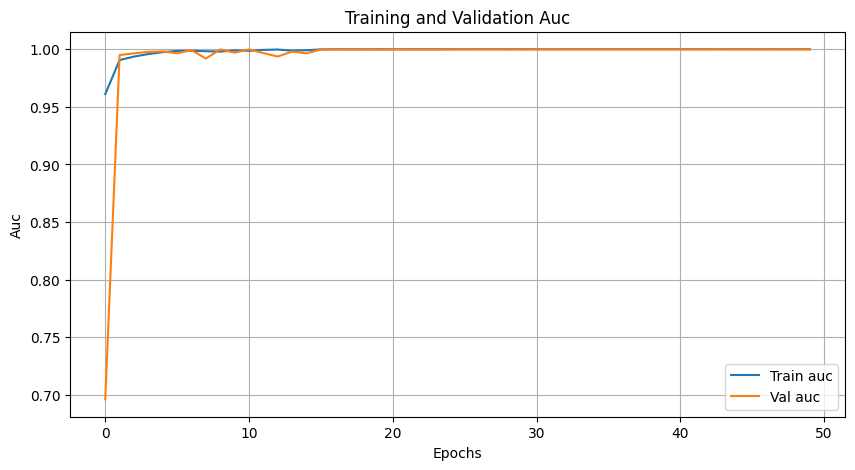

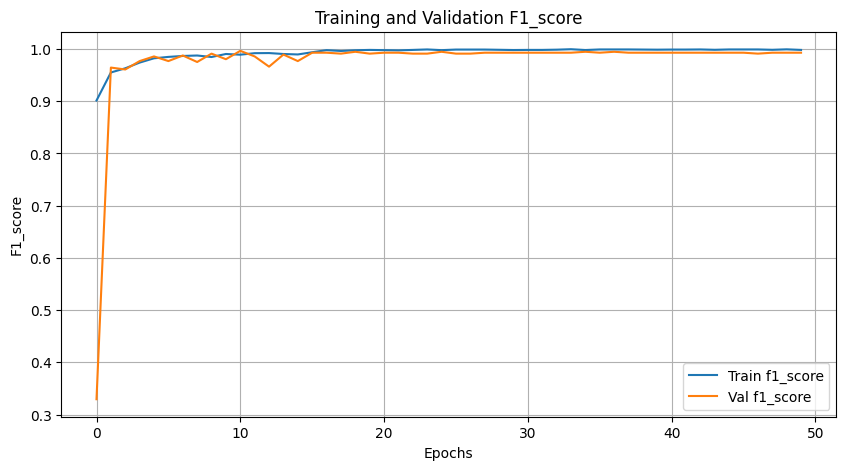

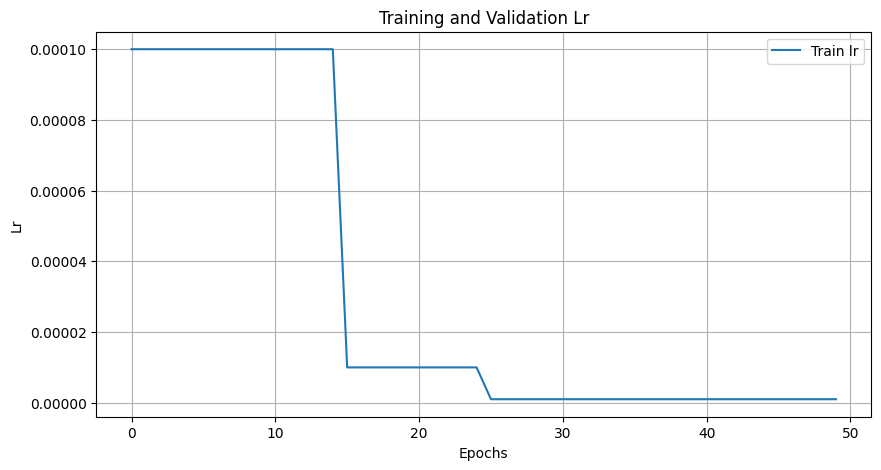

In [18]:
plot_training_history(history)

In [19]:
# Converter o histórico em DataFrame
history = pd.DataFrame(history.history)
# Salvar em CSV
history.to_csv('Recriar_Estudo_6_FLAME_train_history.csv', index=False)

In [20]:
model.save('Recriar_Estudo_6_FLAME.h5')

/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Avaliar

In [21]:
avaliar_modelo(model, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=283, TN=275, FP=1, FN=2
Accuracy       : 0.9947
Precision      : 0.9965
Recall         : 0.9930
F1-Score       : 0.9947
AUC            : 0.9975
Binary Loss    : 0.0320
FDR (Fire Detection Rate)      : 99.30 %
EWR (Error Warning Rate)       : 0.53 %
Confusion Matrix:
[[275   1]
 [  2 283]]


{'TP': 283,
 'TN': 275,
 'FP': 1,
 'FN': 2,
 'accuracy': 0.9946524064171123,
 'precision': 0.9964788732394366,
 'recall': 0.9929824561403509,
 'f1_score': 0.9947275922671354,
 'auc': 0.9974955504703789,
 'loss': 0.03202900013040137,
 'fdr': 99.29824561403508,
 'ewr': 0.53475935828877,
 'confusion_matrix': array([[275,   1],
        [  2, 283]])}

In [22]:
model_best = load_model('Recriar_Estudo_6_FLAME_best.h5')

In [23]:
avaliar_modelo(model_best, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=282, TN=269, FP=7, FN=3
Accuracy       : 0.9822
Precision      : 0.9758
Recall         : 0.9895
F1-Score       : 0.9826
AUC            : 0.9987
Binary Loss    : 0.0554
FDR (Fire Detection Rate)      : 98.95 %
EWR (Error Warning Rate)       : 1.78 %
Confusion Matrix:
[[269   7]
 [  3 282]]


{'TP': 282,
 'TN': 269,
 'FP': 7,
 'FN': 3,
 'accuracy': 0.982174688057041,
 'precision': 0.9757785467128027,
 'recall': 0.9894736842105263,
 'f1_score': 0.9825783972125436,
 'auc': 0.9986778540554284,
 'loss': 0.05537458216478364,
 'fdr': 98.94736842105263,
 'ewr': 1.7825311942959003,
 'confusion_matrix': array([[269,   7],
        [  3, 282]])}

## Testar no FLAME train

In [24]:
data = pd.read_csv("../Datasets/FLAME_train.csv")
image_paths_flame_train = data['image_path'].values
labels_flame_train = data['label_bi'].values

test_ds_flame_train = tf.data.Dataset.from_tensor_slices((image_paths_flame_train, labels_flame_train))
test_ds_flame_train = test_ds_flame_train.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_train, name="FLAME train")

📊 FLAME TRAIN -> Total de imagens: 39375
  Classe 0 (Sem fogo): 14357 imagens (36.46%)
  Classe 1 (Fogo): 25018 imagens (63.54%)
----------------------------------------


In [25]:
avaliar_modelo(model, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=24922, TN=14320, FP=37, FN=96
Accuracy       : 0.9966
Precision      : 0.9985
Recall         : 0.9962
F1-Score       : 0.9973
AUC            : 0.9998
Binary Loss    : 0.0126
FDR (Fire Detection Rate)      : 99.62 %
EWR (Error Warning Rate)       : 0.34 %
Confusion Matrix:
[[14320    37]
 [   96 24922]]


{'TP': 24922,
 'TN': 14320,
 'FP': 37,
 'FN': 96,
 'accuracy': 0.9966222222222222,
 'precision': 0.998517568812853,
 'recall': 0.9961627628107762,
 'f1_score': 0.9973387758368849,
 'auc': 0.999782133599895,
 'loss': 0.012564743930443859,
 'fdr': 99.61627628107762,
 'ewr': 0.3377777777777778,
 'confusion_matrix': array([[14320,    37],
        [   96, 24922]])}

In [26]:
avaliar_modelo(model_best, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=24885, TN=14291, FP=66, FN=133
Accuracy       : 0.9949
Precision      : 0.9974
Recall         : 0.9947
F1-Score       : 0.9960
AUC            : 0.9998
Binary Loss    : 0.0168
FDR (Fire Detection Rate)      : 99.47 %
EWR (Error Warning Rate)       : 0.51 %
Confusion Matrix:
[[14291    66]
 [  133 24885]]


{'TP': 24885,
 'TN': 14291,
 'FP': 66,
 'FN': 133,
 'accuracy': 0.9949460317460318,
 'precision': 0.997354815438259,
 'recall': 0.9946838276440962,
 'f1_score': 0.9960175308691388,
 'auc': 0.9998142982243284,
 'loss': 0.01683473340473389,
 'fdr': 99.46838276440963,
 'ewr': 0.5053968253968254,
 'confusion_matrix': array([[14291,    66],
        [  133, 24885]])}

## Testar no FLAME test

In [27]:
data = pd.read_csv("../Datasets/FLAME_test.csv")
image_paths_flame_test = data['image_path'].values
labels_flame_test = data['label_bi'].values

test_ds_flame_test = tf.data.Dataset.from_tensor_slices((image_paths_flame_test, labels_flame_test))
test_ds_flame_test = test_ds_flame_test.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_test, name="FLAME test")

📊 FLAME TEST -> Total de imagens: 8617
  Classe 0 (Sem fogo): 3480 imagens (40.39%)
  Classe 1 (Fogo): 5137 imagens (59.61%)
----------------------------------------


In [28]:
avaliar_modelo(model, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=5040, TN=3450, FP=30, FN=97
Accuracy       : 0.9853
Precision      : 0.9941
Recall         : 0.9811
F1-Score       : 0.9876
AUC            : 0.9986
Binary Loss    : 0.0467
FDR (Fire Detection Rate)      : 98.11 %
EWR (Error Warning Rate)       : 1.47 %
Confusion Matrix:
[[3450   30]
 [  97 5040]]


{'TP': 5040,
 'TN': 3450,
 'FP': 30,
 'FN': 97,
 'accuracy': 0.9852616920041778,
 'precision': 0.9940828402366864,
 'recall': 0.9811173836869769,
 'f1_score': 0.9875575585382581,
 'auc': 0.9985847547318417,
 'loss': 0.046686663194276105,
 'fdr': 98.11173836869769,
 'ewr': 1.4738307995822213,
 'confusion_matrix': array([[3450,   30],
        [  97, 5040]])}

In [29]:
avaliar_modelo(model_best, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=5062, TN=3286, FP=194, FN=75
Accuracy       : 0.9688
Precision      : 0.9631
Recall         : 0.9854
F1-Score       : 0.9741
AUC            : 0.9937
Binary Loss    : 0.0991
FDR (Fire Detection Rate)      : 98.54 %
EWR (Error Warning Rate)       : 3.12 %
Confusion Matrix:
[[3286  194]
 [  75 5062]]


{'TP': 5062,
 'TN': 3286,
 'FP': 194,
 'FN': 75,
 'accuracy': 0.9687826389694789,
 'precision': 0.963089802130898,
 'recall': 0.9854000389332295,
 'f1_score': 0.9741171942653709,
 'auc': 0.9937287853056147,
 'loss': 0.09912454315726187,
 'fdr': 98.54000389332295,
 'ewr': 3.1217361030521062,
 'confusion_matrix': array([[3286,  194],
        [  75, 5062]])}

## Testar no UAVS Raw Images

In [31]:
data = pd.read_csv("../Datasets/UAVS_RawImages.csv")
image_paths_uavs_raw = data['image_path'].values
labels_uavs_raw = data['label_bi'].values

test_ds_uavs_raw = tf.data.Dataset.from_tensor_slices((image_paths_uavs_raw, labels_uavs_raw))
test_ds_uavs_raw = test_ds_uavs_raw.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_raw, name="UAVS Raw Images")

📊 UAVS RAW IMAGES -> Total de imagens: 1643
  Classe 0 (Sem fogo): 498 imagens (30.31%)
  Classe 1 (Fogo): 1145 imagens (69.69%)
----------------------------------------


In [32]:
avaliar_modelo(model, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=261, TN=404, FP=94, FN=884
Accuracy       : 0.4047
Precision      : 0.7352
Recall         : 0.2279
F1-Score       : 0.3480
AUC            : 0.5717
Binary Loss    : 2.7881
FDR (Fire Detection Rate)      : 22.79 %
EWR (Error Warning Rate)       : 59.53 %
Confusion Matrix:
[[404  94]
 [884 261]]


{'TP': 261,
 'TN': 404,
 'FP': 94,
 'FN': 884,
 'accuracy': 0.40474741326841146,
 'precision': 0.7352112676056338,
 'recall': 0.2279475982532751,
 'f1_score': 0.348,
 'auc': 0.5717016537766788,
 'loss': 2.7880654276407735,
 'fdr': 22.79475982532751,
 'ewr': 59.52525867315885,
 'confusion_matrix': array([[404,  94],
        [884, 261]])}

In [33]:
avaliar_modelo(model_best, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=79, TN=438, FP=60, FN=1066
Accuracy       : 0.3147
Precision      : 0.5683
Recall         : 0.0690
F1-Score       : 0.1231
AUC            : 0.5670
Binary Loss    : 2.6083
FDR (Fire Detection Rate)      : 6.90 %
EWR (Error Warning Rate)       : 68.53 %
Confusion Matrix:
[[ 438   60]
 [1066   79]]


{'TP': 79,
 'TN': 438,
 'FP': 60,
 'FN': 1066,
 'accuracy': 0.3146682897139379,
 'precision': 0.5683453237410072,
 'recall': 0.06899563318777292,
 'f1_score': 0.12305295950155762,
 'auc': 0.5669665561810562,
 'loss': 2.6083033274619982,
 'fdr': 6.899563318777292,
 'ewr': 68.5331710286062,
 'confusion_matrix': array([[ 438,   60],
        [1066,   79]])}

## Testar no UAVS Augmented Images

In [34]:
data = pd.read_csv("../Datasets/UAVS_AugmentedImages.csv")
image_paths_uavs_aug = data['image_path'].values
labels_uavs_aug = data['label_bi'].values

test_ds_uavs_aug = tf.data.Dataset.from_tensor_slices((image_paths_uavs_aug, labels_uavs_aug))
test_ds_uavs_aug = test_ds_uavs_aug.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_aug, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 15560
  Classe 0 (Sem fogo): 7780 imagens (50.00%)
  Classe 1 (Fogo): 7780 imagens (50.00%)
----------------------------------------


In [35]:
avaliar_modelo(model, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1512, TN=6472, FP=1308, FN=6268
Accuracy       : 0.5131
Precision      : 0.5362
Recall         : 0.1943
F1-Score       : 0.2853
AUC            : 0.6403
Binary Loss    : 1.6296
FDR (Fire Detection Rate)      : 19.43 %
EWR (Error Warning Rate)       : 48.69 %
Confusion Matrix:
[[6472 1308]
 [6268 1512]]


{'TP': 1512,
 'TN': 6472,
 'FP': 1308,
 'FN': 6268,
 'accuracy': 0.5131105398457584,
 'precision': 0.5361702127659574,
 'recall': 0.19434447300771207,
 'f1_score': 0.2852830188679245,
 'auc': 0.6402577798190601,
 'loss': 1.6296232449564978,
 'fdr': 19.434447300771208,
 'ewr': 48.688946015424165,
 'confusion_matrix': array([[6472, 1308],
        [6268, 1512]])}

In [36]:
avaliar_modelo(model_best, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=638, TN=7368, FP=412, FN=7142
Accuracy       : 0.5145
Precision      : 0.6076
Recall         : 0.0820
F1-Score       : 0.1445
AUC            : 0.5535
Binary Loss    : 1.8945
FDR (Fire Detection Rate)      : 8.20 %
EWR (Error Warning Rate)       : 48.55 %
Confusion Matrix:
[[7368  412]
 [7142  638]]


{'TP': 638,
 'TN': 7368,
 'FP': 412,
 'FN': 7142,
 'accuracy': 0.5145244215938304,
 'precision': 0.6076190476190476,
 'recall': 0.0820051413881748,
 'f1_score': 0.14450736126840316,
 'auc': 0.5535306897258147,
 'loss': 1.8944950079145406,
 'fdr': 8.20051413881748,
 'ewr': 48.54755784061697,
 'confusion_matrix': array([[7368,  412],
        [7142,  638]])}

## Testar no FireMan

In [37]:
data = pd.read_csv("../Datasets/FireMan_test.csv")
image_paths_fireman = data['image_path'].values
labels_fireman = data['label_bi'].values

test_ds_fireman = tf.data.Dataset.from_tensor_slices((image_paths_fireman, labels_fireman))
test_ds_fireman = test_ds_fireman.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_fireman, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 589
  Classe 0 (Sem fogo): 33 imagens (5.60%)
  Classe 1 (Fogo): 556 imagens (94.40%)
----------------------------------------


In [38]:
avaliar_modelo(model, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=50, TN=33, FP=0, FN=506
Accuracy       : 0.1409
Precision      : 1.0000
Recall         : 0.0899
F1-Score       : 0.1650
AUC            : 0.2025
Binary Loss    : 5.8582
FDR (Fire Detection Rate)      : 8.99 %
EWR (Error Warning Rate)       : 85.91 %
Confusion Matrix:
[[ 33   0]
 [506  50]]


{'TP': 50,
 'TN': 33,
 'FP': 0,
 'FN': 506,
 'accuracy': 0.14091680814940577,
 'precision': 1.0,
 'recall': 0.08992805755395683,
 'f1_score': 0.16501650165016502,
 'auc': 0.2025288859821234,
 'loss': 5.858170310479663,
 'fdr': 8.992805755395683,
 'ewr': 85.90831918505943,
 'confusion_matrix': array([[ 33,   0],
        [506,  50]])}

In [39]:
avaliar_modelo(model_best, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=27, TN=33, FP=0, FN=529
Accuracy       : 0.1019
Precision      : 1.0000
Recall         : 0.0486
F1-Score       : 0.0926
AUC            : 0.1691
Binary Loss    : 6.3247
FDR (Fire Detection Rate)      : 4.86 %
EWR (Error Warning Rate)       : 89.81 %
Confusion Matrix:
[[ 33   0]
 [529  27]]


{'TP': 27,
 'TN': 33,
 'FP': 0,
 'FN': 529,
 'accuracy': 0.10186757215619695,
 'precision': 1.0,
 'recall': 0.048561151079136694,
 'f1_score': 0.09262435677530019,
 'auc': 0.16911925005450185,
 'loss': 6.324683863636428,
 'fdr': 4.856115107913669,
 'ewr': 89.81324278438031,
 'confusion_matrix': array([[ 33,   0],
        [529,  27]])}